In [1]:
# add project root (parent of figures) to module search path
import os
os.chdir(os.path.abspath(".."))  # now CWD is ai_scientist_project/
print("Current working directory:", os.getcwd())

#  import packages
import itertools
import numpy as np
import matplotlib.pyplot as plt

Current working directory: /home/reilly/ai_scientist_project


In [3]:
# Old format of extrating program data for census of the old format

def extract_program_data(census, reference_loss=22.02000046):
    """
    Extracts program data from the census array.

    Parameters:
    census (np.ndarray): The census array containing program data.
    
    Returns:
    tuple: A tuple containing losses, times, parent1_id, parent2_id, and program_id.
    """
    n_iterations = census.shape[0] - 1  # number of iterations (excluding the initial state)
    n_islands = census.shape[1]  # number of islands - 1
    batch_size = census.shape[2]  # batch size

    # get the relevant data from the census
    losses = [census[0, -1, 0][1], census[0, -1, 1][1]]  # initialize losses with seed losses
    times = [census[0, -1, 0][2], census[0, -1, 1][2]]  # initialize times with seed times
    program_tuple_id = [(0, 8, 0), (0, 8, 1)]  # initialize program ids with seed program ids
    parent1_tuple_id = ['none', 'none']  # initialize parent ids with 'none'
    parent2_tuple_id = ['none', 'none']  # initialize parent ids with 'none'
    parent1_int_id = [-1, -1]  # initialize parent ids with -1
    parent2_int_id = [-1, -1]  # initialize parent ids with -1
    llm_name = ['seed_model', 'seed_model']  # initialize LLMs with seed model
    y_eval = [census[0, -1, 0][-1], census[0, -1, 1][-1]]  # initialize y_eval with seed y_eval

    for i, j, k in itertools.product(range(n_iterations), range(n_islands), range(batch_size)):
        if census[i+1, j, k] is None:
            continue  # skip if census entry is None
        # we only want to get data for programs whose parents are already in our data
        p1_tuple_id, p2_tuple_id = census[i+1, j, k][3], census[i+1, j, k][4]
        p1_int_id = np.where([tuple(p1_tuple_id) == pid for pid in program_tuple_id])[0]
        p2_int_id = np.where([tuple(p2_tuple_id) == pid for pid in program_tuple_id])[0]
        if len(p1_int_id) == 0 or len(p2_int_id) == 0:
            continue
        
        # disregard programs with loss = np.nan or loss > 50
        loss = np.nan_to_num(census[i+1, j, k][1], nan=100)  # replace NaN with a large number
        if loss > 50:
            continue

        # if you got this far, congrats! you may be added to the data
        times.append(census[i+1, j, k][2])
        losses.append(census[i+1, j, k][1])
        program_tuple_id.append((i+1, j, k))
        parent1_tuple_id.append(p1_tuple_id)
        parent2_tuple_id.append(p2_tuple_id)
        parent1_int_id.append(p1_int_id[0])
        parent2_int_id.append(p2_int_id[0])
        llm_name.append(census[i+1, j, k][0])
        y_eval.append(census[i+1, j, k][-1])


    # convert to numpy arrays
    losses = np.array(losses, dtype=float)
    times = np.array(times, dtype=float)
    parent1_id = np.array(parent1_int_id, dtype=int)
    parent2_id = np.array(parent2_int_id, dtype=int)
    llm_name = np.array(llm_name, dtype=str)
    y_eval = np.array(y_eval, dtype=float)

    # subtract the start time from all times
    times = times - np.min(times)

    # get scores
    losses_relative = losses - reference_loss  # relative losses
    scores = np.exp(-losses_relative)  # convert losses to scores
    running_max_scores = np.maximum.accumulate(scores)  # running max scores

    # look for innovations (where the max score increases) and get the indices
    innovation_threshold = 0.01  # threshold for innovation detection
    innovation_indices = np.where(np.diff(running_max_scores) > innovation_threshold)[0] + 1
    innovation_indices = innovation_indices.tolist()  # convert to list for easier manipulation
    innovation_indices = [1] + innovation_indices  # include the first index

    # build family tree of winner
    index = np.argmax(scores)
    generations = [[index]]
    # now go through the most recent generation and find the parents
    all_seed = False
    while not all_seed:
        current_generation = generations[-1]
        all_seed = all([i < 2 for i in current_generation])  # check if all are seed programs
        parent_generation = []
        for idx in current_generation:
            p1_idx, p2_idx = parent1_id[idx], parent2_id[idx]
            if p1_idx >= 0:
                parent_generation.append(p1_idx)
            if p2_idx >= 0:
                parent_generation.append(p2_idx)
        parent_generation = list(set(parent_generation))
        if len(parent_generation) == 0:
            break
        generations.append(parent_generation)


    results_dict = {
        'scores': scores,
        'losses': losses,
        'running_max_scores': running_max_scores,
        'times': times,
        'parent1_id': parent1_id,
        'parent2_id': parent2_id,
        'program_id': program_tuple_id,
        'llm_name': llm_name,
        'innovation_indices': innovation_indices,
        'generations': generations,
        'y_eval': y_eval,
    }
    return results_dict

In [4]:
def extract_program_data_new(census, reference_loss=22.02000046):
    """
    Extracts program data from the NEW census arrays. These are not stored in such a stupid way as the old ones.
    Each program is a row in a long numpy array with the following columns:
    - 0: iteration number
    - 1: island number
    - 2: batch number
    - 3: LLM name
    - 4: loss
    - 5: time in seconds
    - 6: parent1 id (int)
    - 7: parent2 id (int)
    - 8: y_eval (float)
     
    Returns a dictionary with the following keys
    - 'scores': np.ndarray of scores (exp(-(loss - reference_loss)))
    - 'losses': np.ndarray of losses
    - 'running_max_scores': np.ndarray of running max scores
    - 'times': np.ndarray of times in seconds
    - 'parent1_id': np.ndarray of parent1 ids (int)
    - 'parent2_id': np.ndarray of parent2 ids (int)
    - 'program_id': list of tuples representing the program ids in format (iteration, island
    , batch)
    - 'llm_name': np.ndarray of LLM names (str)
    - 'innovation_indices': list of indices where innovations occurred (where the max score increases)
    - 'generations': list of lists, where generations[k] is a list of the kth order ancestors of the winner.
                     So generations[0] = [winner_index], generations[1] = [parent1_index, parent2_index], etc.
    - 'y_eval': np.ndarray of y_eval values (float)
    """
    # extract data from the census
    n_programs = census.shape[0]  # number of programs
    losses = census[:, 4]  # losses
    times = census[:, 5]  # times in seconds
    program_tuple_id = [tuple(census[i, :3]) for i in range(n_programs)]  # program ids as tuples (iteration, island, batch)
    parent1_tuple_id = census[:, 6]  # parent1 ids
    parent2_tuple_id = census[:, 7]  # parent2 ids
    llm_name = census[:, 3]  # LLM names
    y_eval = census[:, 8]  # y_eval values

    # now loop through all programs with index >= 2 and find their parents
    parent1_int_id = [-1, -1]  # initialize parent ids with -1
    parent2_int_id = [-1, -1]  # initialize parent ids with -1
    for i in range(2, n_programs):
        p1_tuple_id = parent1_tuple_id[i]
        p2_tuple_id = parent2_tuple_id[i]
        # print(f"Processing program {i}: {program_tuple_id[i]}, parents: {p1_tuple_id}, {p2_tuple_id}")
        # print(f"p1_tuple_id.dtype: {type(p1_tuple_id)}, p2_tuple_id.dtype: {type(p2_tuple_id)}")
        p1_int_id = program_tuple_id.index(p1_tuple_id)
        p2_int_id = program_tuple_id.index(p2_tuple_id)
        # print(f"p1_int_id: {p1_int_id}, p2_int_id: {p2_int_id}")
        parent1_int_id.append(p1_int_id)
        parent2_int_id.append(p2_int_id)
    # check everyone has 2 parents
    assert len(parent1_int_id) == n_programs, "parent1_int_id must have the same length as census"
    assert len(parent2_int_id) == n_programs, "parent2_int_id must have the same length as census"

    # convert to numpy arrays
    parent1_id = np.array(parent1_int_id, dtype=int)
    parent2_id = np.array(parent2_int_id, dtype=int)
    llm_name = np.array(llm_name, dtype=str)
    # subtract the start time from all times
    times = times - np.min(times)
    # get scores
    losses = np.array(losses, dtype=float)
    losses_relative = losses - reference_loss  # relative losses
    scores = np.exp(-losses_relative)  # convert losses to scores
    running_max_scores = np.maximum.accumulate(scores)  # running max scores
    # look for innovations (where the max score increases) and get the indices
    innovation_threshold = 0.01  # threshold for innovation detection
    innovation_indices = np.where(np.diff(running_max_scores) > innovation_threshold)[0]
    innovation_indices = innovation_indices.tolist()  # convert to list for easier manipulation
    innovation_indices = [1] + innovation_indices  # include the first index

    # build family tree of winner
    index = np.argmax(scores)
    generations = [[index]]
    # now go through the most recent generation and find the parents
    all_seed = False
    while not all_seed:
        current_generation = generations[-1]
        all_seed = all([i < 2 for i in current_generation])  # check if all are seed programs
        parent_generation = []
        for idx in current_generation:
            p1_idx, p2_idx = parent1_id[idx], parent2_id[idx]
            if p1_idx >= 0:
                parent_generation.append(p1_idx)
            if p2_idx >= 0:
                parent_generation.append(p2_idx)
        parent_generation = list(set(parent_generation))
        if len(parent_generation) == 0:
            break
        generations.append(parent_generation)

    results_dict = {
        'scores': scores,
        'losses': losses,
        'running_max_scores': running_max_scores,
        'times': times,
        'parent1_id': parent1_id,
        'parent2_id': parent2_id,
        'program_id': program_tuple_id,
        'llm_name': llm_name,
        'innovation_indices': innovation_indices,
        'generations': generations,
        'y_eval': y_eval,
    }
    return results_dict

In [132]:
# get the program data from the census

census_paths = [# 'program_databases/07-15/16-22-07 (big_only)/combined/census.npy',
                # 'program_databases/07-15/17-05-19 (big_only)/combined/census.npy',
                # 'program_databases/07-15/17-48-16 (big_only)/combined/census.npy',
                # 'program_databases/07-15/18-31-33 (big_only)/combined/census.npy',

                # 'program_databases/07-16/00-59-22 (mix)/combined/census.npy',
                # 'program_databases/07-16/01-46-55 (mix)/combined/census.npy',
                # 'program_databases/07-16/02-29-34 (mix)/combined/census.npy',
                # 'program_databases/07-16/03-15-03 (mix)/combined/census.npy',

                # 'program_databases/07-20/01-37-40 (image feedback)/combined/census.npy',
                # 'program_databases/07-20/02-43-00 (image feedback)/combined/census.npy',
                # 'program_databases/07-20/03-45-10 (image feedback)/combined/census.npy',
                # 'program_databases/07-20/04-47-23 (image feedback)/combined/census.npy',

                # 'program_databases/07-16/12-46-54 (big + no_image)/combined/census.npy',
                # 'program_databases/07-16/13-18-43 (big + no_image)/combined/census.npy',
                # 'program_databases/07-16/13-51-51 (big + no_image)/combined/census.npy',
                # 'program_databases/07-16/14-23-46 (big + no_image)/combined/census.npy',

                # 'program_databases/07-16/10-46-45 (mix + no_image)/combined/census.npy',
                # 'program_databases/07-16/11-18-03 (mix + no_image)/combined/census.npy',
                # 'program_databases/07-16/11-48-51 (mix + no_image)/combined/census.npy',
                # 'program_databases/07-16/12-18-10 (mix + no_image)/combined/census.npy',

                # 'program_databases/07-17/11-02-49 (mix + no_image)/combined/census.npy',
                # 'program_databases/07-17/11-42-11 (mix + no_image)/combined/census.npy',
                # 'program_databases/07-17/12-22-36 (mix + no_image)/combined/census.npy',
                # 'program_databases/07-17/14-55-12 (mix + no_image)/combined/census.npy',
                
                # 'program_databases/07-17/07-14-37 (mix + image)/combined/census.npy',
                # 'program_databases/07-17/08-10-17 (mix + image)/combined/census.npy',
                # 'program_databases/07-17/09-07-26 (mix + image)/combined/census.npy',
                # 'program_databases/07-17/10-05-55 (mix + image)/combined/census.npy',

                # 'program_databases/07-17/04-58-28 (no_param_est)/combined/census.npy',
                # 'program_databases/07-17/05-31-58 (no_param_est)/combined/census.npy',
                # 'program_databases/07-17/06-05-20 (no_param_est)/combined/census.npy',
                # 'program_databases/07-17/06-40-16 (no_param_est)/combined/census.npy',

                # 'program_databases/07-17/19-02-25 (no_gradient)/combined/census.npy',
                # 'program_databases/07-17/20-10-14 (no_gradient)/combined/census.npy',
                # 'program_databases/07-17/21-11-44 (no_gradient)/combined/census.npy',
                # 'program_databases/07-17/22-13-56 (no_gradient)/combined/census.npy',

                # 'program_databases/07-20/05-52-26 (no image)/combined/census.npy',
                # 'program_databases/07-20/06-26-59 (no image)/combined/census.npy',
                # 'program_databases/07-20/07-01-03 (no image)/combined/census.npy',
                # 'program_databases/07-20/07-35-59 (no image)/combined/census.npy',

                # 'program_databases/07-21/15-31-23 (no_image)/combined/census.npy',
                # 'program_databases/07-21/18-30-33 (no_image)/combined/census.npy',
                # 'program_databases/07-21/19-33-36 (no_image)/combined/census.npy',
                # 'program_databases/07-21/20-34-39 (no_image)/combined/census.npy',

                # 'program_databases/07-22/02-35-30 (no image)/combined/census.npy',
                # 'program_databases/07-22/03-16-56 (no image)/combined/census.npy',
                # 'program_databases/07-22/04-01-16 (no image)/combined/census.npy',
                # 'program_databases/07-22/04-47-09 (no image)/combined/census.npy',

                # 'program_databases/07-22/05-31-26 (image)/combined/census.npy',
                # 'program_databases/07-22/06-16-02 (image)/combined/census.npy',
                # 'program_databases/07-22/07-00-37 (image)/combined/census.npy',
                # 'program_databases/07-22/07-45-07 (image)/combined/census.npy',
                # 'program_databases/07-23/01-00-00 (image)/combined/census.npy',

                # 'program_databases/07-23/03-10-12 (text)/combined/census.npy',
                # 'program_databases/07-23/04-09-16 (text)/combined/census.npy',
                # 'program_databases/07-23/05-08-08 (text)/combined/census.npy',
                # 'program_databases/07-23/06-07-12 (text)/combined/census.npy',

                # 'program_databases/07-22/23-18-55 (image)/combined/census.npy',
                # 'program_databases/07-23/00-21-26 (image)/combined/census.npy',
                # 'program_databases/07-23/01-16-39 (image)/combined/census.npy',
                # 'program_databases/07-23/02-14-04 (image)/combined/census.npy',

                'program_databases/07-25/02-37-04 (text)/combined/census.npy',
                'program_databases/07-25/03-09-53 (text)/combined/census.npy',
                'program_databases/07-25/03-46-44 (text)/combined/census.npy',
                'program_databases/07-25/04-23-26 (text)/combined/census.npy',

                'program_databases/07-24/11-11-47 (image)/combined/census.npy',
                'program_databases/07-24/16-00-29 (image)/combined/census.npy',
                'program_databases/07-24/16-52-24 (image)/combined/census.npy',
                'program_databases/07-24/17-44-31 (image)/combined/census.npy',
                
                # 'program_databases/07-30/15-16-32/combined/census.npy',
                # 'program_databases/07-30/16-11-02/combined/census.npy',
                # 'program_databases/07-30/17-01-31/combined/census.npy',

                'program_databases/07-30/17-52-59 (complexity penalty)/combined/census.npy',
                'program_databases/07-30/18-44-20 (complexity penalty)/combined/census.npy',
                'program_databases/07-30/19-31-37 (complexity penalty)/combined/census.npy',
                ]

results_list = []
for i, path in enumerate(census_paths):
    census = np.load(path, allow_pickle=True)
    print(f"Processing {path}...")
    results = extract_program_data_new(census, reference_loss=28.85)  # using the new function
    results_list.append(results)

Processing program_databases/07-25/02-37-04 (text)/combined/census.npy...
Processing program_databases/07-25/03-09-53 (text)/combined/census.npy...
Processing program_databases/07-25/03-46-44 (text)/combined/census.npy...
Processing program_databases/07-25/04-23-26 (text)/combined/census.npy...
Processing program_databases/07-24/11-11-47 (image)/combined/census.npy...
Processing program_databases/07-24/16-00-29 (image)/combined/census.npy...
Processing program_databases/07-24/16-52-24 (image)/combined/census.npy...
Processing program_databases/07-24/17-44-31 (image)/combined/census.npy...
Processing program_databases/07-30/17-52-59 (complexity penalty)/combined/census.npy...
Processing program_databases/07-30/18-44-20 (complexity penalty)/combined/census.npy...
Processing program_databases/07-30/19-31-37 (complexity penalty)/combined/census.npy...


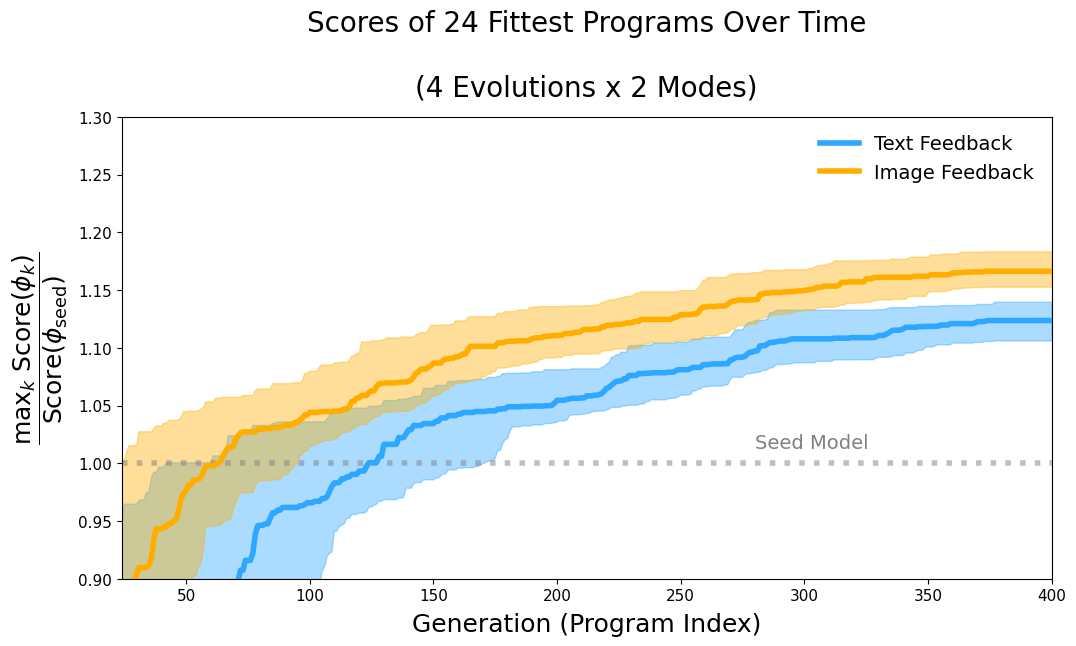

In [134]:
fig, ax = plt.subplots(figsize=(12, 6))

colours = [ '#2da7ff', '#ffae00']
labels = ['Text Feedback', 'Image Feedback']
k = 24  # number of top scores to plot
# for each run, plot the top k scores at each time bin
n_simulations = len(results_list)
n_programs = min([len(results['scores']) for results in results_list])

top_scores = np.zeros((n_simulations, n_programs - k, k))  # to store the top k scores at each time bin
for i in np.arange(n_simulations):
    group_index = i < 4
    x = np.arange(k, n_programs)
    y = results_list[i]['scores'][k:n_programs]
    # get the top k scores for iter <= i for each i
    for j in range(k, n_programs):
        idx1 = j - k
        top_scores[i, idx1, :] = np.sort(y[:j])[-k:]

for i in range(len(colours)):
    x = np.arange(k, n_programs)
    group_median = np.median(top_scores[4*i:4*(i+1), :, :], axis=(0, 2))  # median over the 4 runs in the group
    ax.plot(x, group_median, color=colours[i], linewidth=4, label=labels[i])
    group_iqr = np.percentile(top_scores[4*i:4*(i+1), :, :], [25, 75], axis=(0, 2))  # IQR over the 4 runs in the group
    ax.fill_between(x, group_iqr[0], group_iqr[1], color=colours[i], alpha=0.4, zorder=0)

# plot horizontal line at y=1.0
ax.axhline(y=1.0, color='grey', linestyle=':', linewidth=4, alpha=0.5, zorder=0)
# add text annotation for the horizontal line
ax.text(n_programs - 75, 1.01, r'Seed Model', color='grey', fontsize=14, ha='right', va='bottom')

ax.set_title(f"Scores of {k} Fittest Programs Over Time\n\n(4 Evolutions x 2 Modes)", fontsize=20, pad=15)
ax.set_xlabel("Generation (Program Index)", fontsize=18, labelpad=6)
ax.set_ylabel(r"$\dfrac{\text{max}_k \ \text{Score}(\phi_k)}{\text{Score}(\phi_{\text{seed}})}$",
              fontsize=18, labelpad=6)

ax.legend(loc='upper right', fontsize=14, frameon=False)
ax.set_xlim(k, n_programs - 1)
ax.set_ylim(0.9, 1.3)
# ax.set_yticks([0.9, 1.0, 1.1, 1.2, 1.3])
# ax.set_xticks([100, 200, 300, 400])
ax.tick_params(axis='both', labelsize=11)
plt.show()

In [157]:
improvements_thinking_model = []
improvements_small_model = []
score_thinking_model = []
score_small_model = []
loss_parent_thinking_model = []
loss_parent_small_model = []

for experiment_no, results in enumerate(results_list):
    for i in range(2, len(results['losses'])):
        # skip if iteration is too early
        if results['program_id'][i][0] < 2:
            continue
        llm_name = results['llm_name'][i]
        # losses
        parent_loss = results['losses'][results['parent2_id'][i]]
        improvement = parent_loss - results['losses'][i]
        # scores
        # parent_score = results['scores'][results['parent2_id'][i]]
        # improvement = results['scores'][i] - parent_score
        if '2.5-flash' in llm_name:
            improvements_thinking_model.append(improvement)
            score_thinking_model.append(results['scores'][i])
            loss_parent_thinking_model.append(results['losses'][results['parent2_id'][i]])
        else:
            improvements_small_model.append(improvement)
            score_small_model.append(results['scores'][i])
            loss_parent_small_model.append(results['losses'][results['parent2_id'][i]])

# Convert lists to numpy arrays
score_small_model = np.array(score_small_model)
score_thinking_model = np.array(score_thinking_model)
improvements_small_model = np.array(improvements_small_model)
improvements_thinking_model = np.array(improvements_thinking_model)
loss_parent_thinking_model = np.array(loss_parent_thinking_model)
loss_parent_small_model = np.array(loss_parent_small_model)

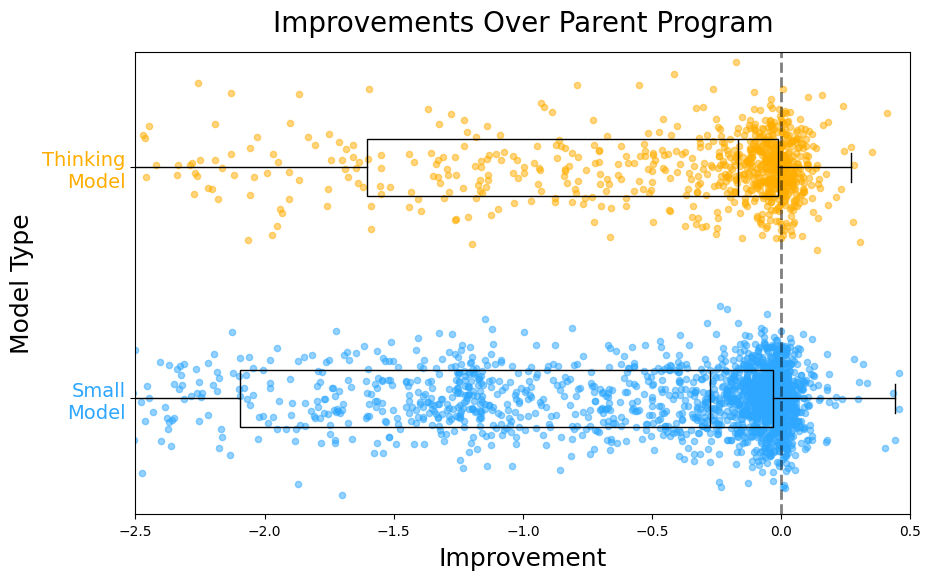

In [163]:
plt.figure(figsize=(10, 6))

# Scatter plots
y_jitter_small = np.random.standard_normal(len(improvements_small_model)) * 0.25
y_jitter_thinking = np.random.standard_normal(len(improvements_thinking_model)) * 0.25

plt.scatter(x=improvements_small_model, 
            y=np.ones(len(improvements_small_model)) + y_jitter_small,
            color='#2da7ff', label=f'prob(improve) = {np.sum(improvements_small_model > 0) / len(improvements_small_model):.2f}',
            alpha=0.5, s=20)
plt.scatter(x=improvements_thinking_model, 
            y=np.ones(len(improvements_thinking_model)) * 3 + y_jitter_thinking,
            color='#ffae00', label=f'prob(improve) = {np.sum(improvements_thinking_model > 0) / len(improvements_thinking_model):.2f}',
            alpha=0.5, s=20)

# Box-and-whisker plots with transparent box face color
plt.boxplot(improvements_small_model, positions=[1], vert=False, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='none', edgecolor='k', alpha=1), medianprops=dict(color='black'),
            showfliers=False, whis=[10, 99])
plt.boxplot(improvements_thinking_model, positions=[3], vert=False, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='none', edgecolor='k', alpha=1), medianprops=dict(color='black'),
            showfliers=False, whis=[10, 99])

# Vertical line at x=0
plt.axvline(x=0, color='k', linestyle='--', linewidth=2, alpha=0.5)

# Title and labels
plt.title("Improvements Over Parent Program", fontsize=20, pad=15)
plt.xlabel("Improvement", fontsize=18, labelpad=6)

# Set y-ticks with colored text
ax = plt.gca()
ax.set_yticks([1, 3])
ax.set_yticklabels(['Small\nModel', 'Thinking\nModel'], fontsize=14)

# Set the colors of y-tick labels to match the scatter colors
tick_labels = ax.get_yticklabels()
tick_labels[0].set_color('#2da7ff')  # Small Model in blue
tick_labels[1].set_color('#ffae00')  # Thinking Model in orange

plt.ylabel("Model Type", fontsize=18, labelpad=6)
# plt.legend(loc='upper right', fontsize=14, frameon=False)
plt.ylim(0, 4)
# plt.xlim(-1.25, 0.5)
plt.xlim(-2.5, 0.5)

plt.show()

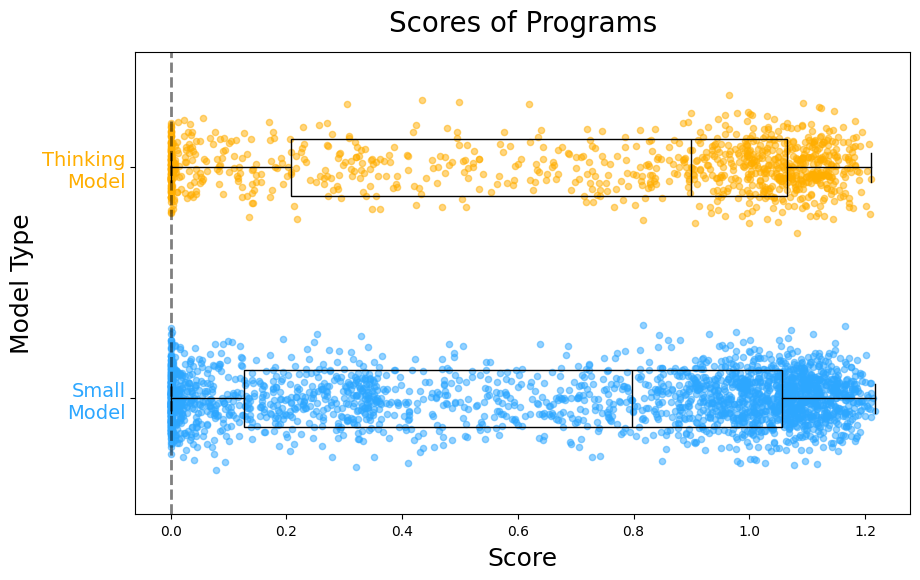

In [165]:
plt.figure(figsize=(10, 6))

# Scatter plots
y_jitter_small = np.random.standard_normal(len(score_small_model)) * 0.2
y_jitter_thinking = np.random.standard_normal(len(score_thinking_model)) * 0.2

plt.scatter(x=score_small_model, 
            y=np.ones(len(score_small_model)) + y_jitter_small,
            color='#2da7ff', label='small model', alpha=0.5, s=20)
plt.scatter(x=score_thinking_model, 
            y=np.ones(len(score_thinking_model)) * 3 + y_jitter_thinking,
            color='#ffae00', label='thinking model', alpha=0.5, s=20)

# Box-and-whisker plots with transparent box face color
plt.boxplot(score_small_model, positions=[1], vert=False, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='none', edgecolor='k', alpha=1), medianprops=dict(color='black'),
            showfliers=False)
plt.boxplot(score_thinking_model, positions=[3], vert=False, widths=0.5, patch_artist=True,
            boxprops=dict(facecolor='none', edgecolor='k', alpha=1), medianprops=dict(color='black'),
            showfliers=False)

# Vertical line at x=0
plt.axvline(x=0, color='k', linestyle='--', linewidth=2, alpha=0.5)

# Title and labels
plt.title("Scores of Programs", fontsize=20, pad=15)
plt.xlabel("Score", fontsize=18, labelpad=6)

# Set y-ticks with colored text
ax = plt.gca()
ax.set_yticks([1, 3])
ax.set_yticklabels(['Small\nModel', 'Thinking\nModel'], fontsize=14)

# Set the colors of y-tick labels to match the scatter colors
tick_labels = ax.get_yticklabels()
tick_labels[0].set_color('#2da7ff')  # Small Model in blue
tick_labels[1].set_color('#ffae00')  # Thinking Model in orange

plt.ylabel("Model Type", fontsize=18, labelpad=6)
plt.ylim(0, 4)
plt.show()

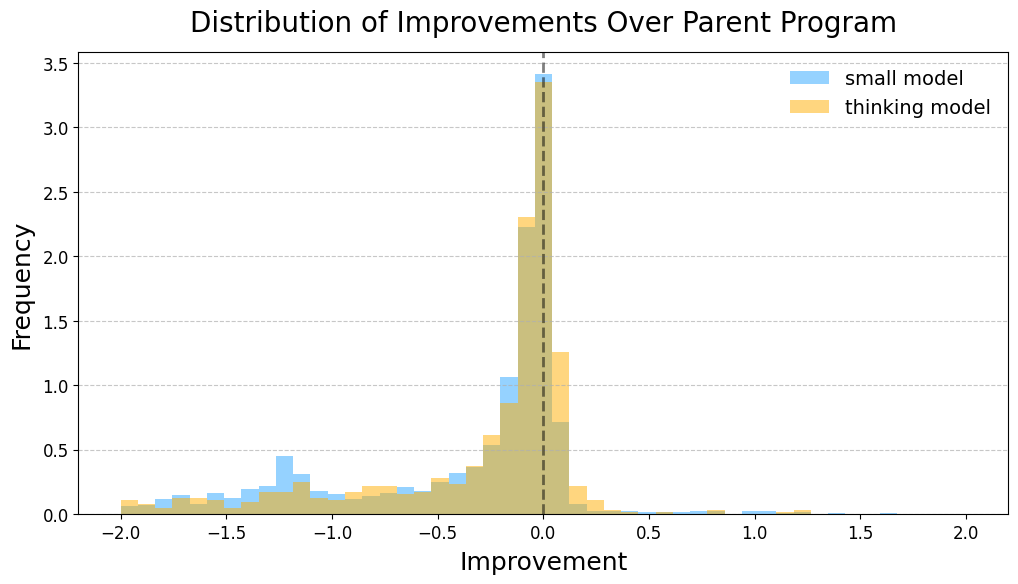

In [160]:
plt.figure(figsize=(12, 6))
plt.hist(improvements_small_model, bins=np.linspace(-2, 2, 50),
         color='#2da7ff', alpha=0.5, label='small model', density=True)
plt.hist(improvements_thinking_model, bins=np.linspace(-2, 2, 50),
         color='#ffae00', alpha=0.5, label='thinking model', density=True)
plt.axvline(x=0, color='k', linestyle='--', linewidth=2, alpha=0.5)
plt.title("Distribution of Improvements Over Parent Program", fontsize=20, pad=15)
plt.xlabel("Improvement", fontsize=18, labelpad=6)
plt.ylabel("Frequency", fontsize=18, labelpad=6)
plt.legend(loc='upper right', fontsize=14, frameon=False)
# plt.xlim(-10, 5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()